In [123]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
import numpy as np

import matplotlib.pyplot as plt

In [124]:
#%%capture
# @title Generating dataset from a perceptual decision making task
#! git clone https://github.com/neurogym/neurogym.git
# %cd neurogym/
# ! pip install -e .

c:\Users\guyda\anaconda\envs\ce-rnn\lib\site-packages\gym\utils\passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
c:\Users\guyda\anaconda\envs\ce-rnn\lib\site-packages\gym\utils\passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
c:\Users\guyda\anaconda\envs\ce-rnn\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


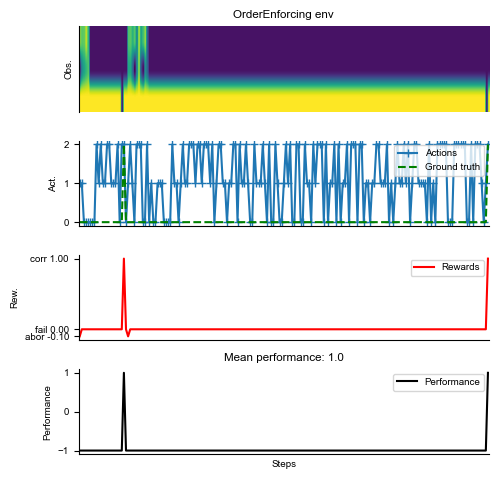

In [125]:
import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'PerceptualDecisionMakingDelayResponse-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
dt=20
hidden_size=64
batch_size=16
seq_len=100

kwargs={'dt': dt, 'timing': timing}

dataset = ngym.Dataset(
    task, kwargs, batch_size=batch_size,
    seq_len=seq_len)
env = dataset.env
act_size = env.action_space.n


# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

Define Leaky RNN class for task

In [126]:
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None,sigma_rec=0.15, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec


        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        h_new += self._sigma_rec * torch.randn_like(h_new)

        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class LeakyNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.input_size = input_size
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

Train leaky RNN on task

LeakyNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=64, bias=True)
    (h2h): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Step 100, Loss 0.5086
Step 200, Loss 0.3264
Step 300, Loss 0.3080
Step 400, Loss 0.3057
Step 500, Loss 0.2932
Step 600, Loss 0.2860
Step 700, Loss 0.2863
Step 800, Loss 0.2855
Step 900, Loss 0.2853
Step 1000, Loss 0.2781
Step 1100, Loss 0.2839
Step 1200, Loss 0.2776
Step 1300, Loss 0.2788
Step 1400, Loss 0.2826
Step 1500, Loss 0.2846
Step 1600, Loss 0.2832
Step 1700, Loss 0.2724
Step 1800, Loss 0.2733
Step 1900, Loss 0.2772
Step 2000, Loss 0.2801


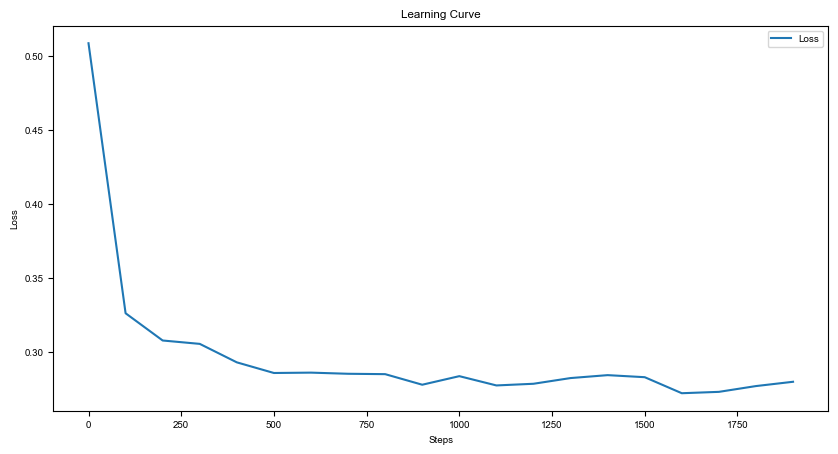

In [127]:
net = LeakyNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
print(net)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 100
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
steps = np.arange(0, 2000, print_step)
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(steps,loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

np.save('./npArrays/baseLoss.npy', loss_values)

Run the network post-training and record neural activity


In [128]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['decision']]
    #stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Average performance 0.484


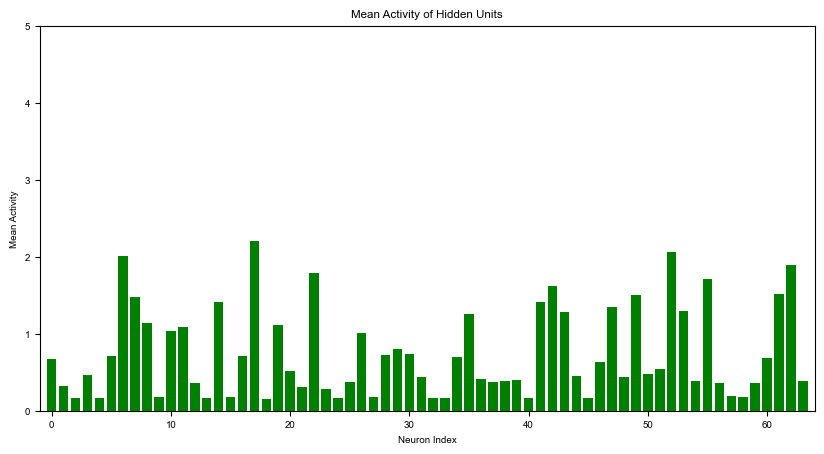

In [ ]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

trial = 2

def plot_activity(activity, threshold=0.1):
    """
    Plots the activity of the neural network's activity.

    Parameters:
    activity (numpy.ndarray): Neural activity array of shape (time_steps, hidden_size).
    threshold (float): Threshold below which activity is considered sparse.
    """
    activity = np.mean(np.abs(activity), axis=0)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(activity)), activity,color='brown')
    plt.xlabel('Neuron Index')
    plt.ylabel('Mean Activity')
    plt.ylim(0,5.5)
    plt.xlim(-1,hidden_size)
    plt.title('Neural Network Activity')
    plt.show()
plot_activity(activity_dict[trial])

Shape of the neural activity (Time points, Neurons): (99325, 64)
Shape of the projected activity for standard leaky RNN (Time points, PCs): (99325, 2)


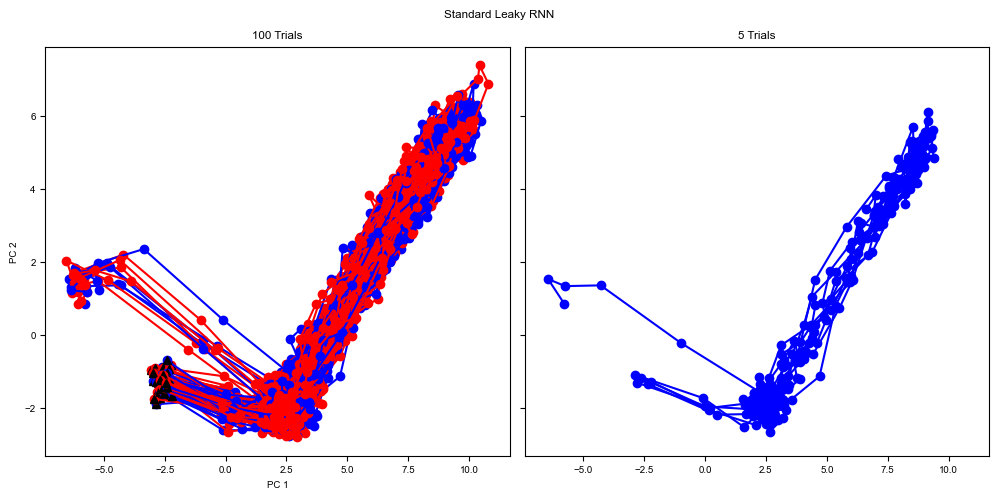

In [130]:
from sklearn.decomposition import PCA
num_trial = len(activity_dict)  
### Play with different values here to understand the dynamics
plot_until_time = 70



# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)


# Initialize PCA and fit it on the activity data
pca = PCA(n_components=2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D)

print('Shape of the projected activity for standard leaky RNN (Time points, PCs):', activity_pc.shape)


# Visualization
import matplotlib.pyplot as plt

def plot_trials(activity_dict, trial_infos, plot_until_time, title, ax1_title, ax2_title):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

    # Plot all trials in ax1 and fewer trials in ax2 for clarity
    for i in range(100):
        # Transform and plot each trial
        activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

        # Color by ground truth
        trial = trial_infos[i]
        color = 'red' if trial['ground_truth'] == 1 else 'blue'

        ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
        if i < 5:  # Fewer trials in ax2 for clear visualization
            ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

        # Indicate trial start with a different marker
        ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

    # Setting labels and titles for clarity
    ax1.set_title(ax1_title)
    ax2.set_title(ax2_title)
    ax1.set_xlabel('PC 1')
    ax1.set_ylabel('PC 2')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Plot for standard leaky RNN
plot_trials(activity_dict=activity_dict, trial_infos=trial_infos, plot_until_time=plot_until_time,
    title="Standard Leaky RNN", ax1_title="100 Trials", ax2_title="5 Trials")


In [131]:
import sys
sys.path.append('./fixed-point-finder')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch
# Now you can create an instance of FixedPointFinderTorch with your RNN

class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 1.38e+00 +/- 2.31e-01
		dq = 2.97e-01 +/- 2.46e-01
		learning rate = 1.97e-07
		avg iter time = 9.11e-04 sec
	Identified 10 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 10).
	Computing recurrent Jacobian at 10 unique fixed points.
	Computing input Jacobian at 10 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



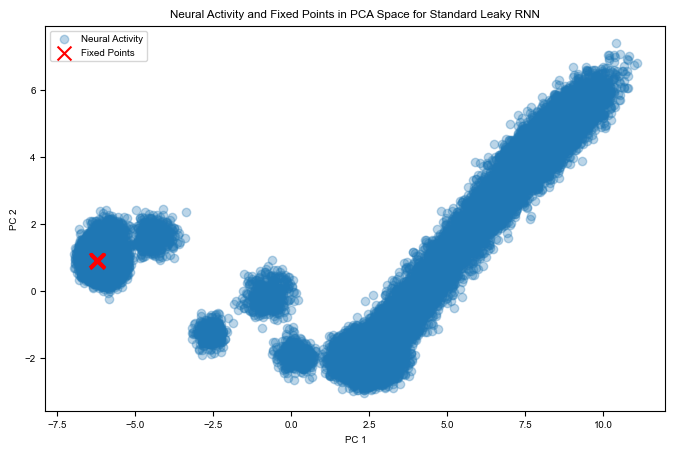

In [132]:
# Instantiate the FixedPointRNNWrapper with the model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(net.rnn, batch_first=False)


# Instantiate FixedPointFinder with the wrapped models
finder = FixedPointFinder(rnn_model_fixed_point)



# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, net.rnn.hidden_size)  # 10 random initial hidden states (one for each hidden unit)
inputs = torch.zeros(10, net.input_size)  # Zero input for each initial condition


# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Find fixed points (Check FixedPointFinder documentation)
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)


# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute

# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]activity_list = []


# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]


pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)

pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)

fixed_points_pc = pca.transform(fixed_points_array)


# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space for Standard Leaky RNN")
plt.legend()
plt.show()# Plot activity and fixed points


